In [1]:
import hydra 

hydra.initialize(config_path="src/config")
cfg = hydra.compose(config_name='train', overrides=None, return_hydra_config=True)

C:\Users\tomma\AppData\Local\Temp\ipykernel_11856\176895419.py:3: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="src/config")


In [5]:
import dgl
import ipywidgets as widgets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import py3Dmol
import pymatgen.core as mg
import seaborn as sns
import torch
from IPython import display
from ipywidgets import Button, Dropdown, HBox, VBox
from src.lib.models import MyEGATRegressor
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, f1_score)
from tqdm.notebook import tqdm

from matgl.layers._basis import GaussianExpansion

In [6]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self,graphs,targets):
        super(MyDataset).__init__()
        self.graphs = graphs
        self.targets = targets
        
    def __getitem__(self,idx):
        return self.graphs[idx],self.targets[idx]
    
    def __len__(self):
        return len(self.graphs)

In [7]:
def get_cmap():
    df_colors = pd.read_csv("https://raw.githubusercontent.com/CorySimon/JMolColors/master/jmolcolors.csv")

    colors = ['#000000']
    for i in range(1,95):
        atom = mg.Element.from_Z(i).name
        r = df_colors[df_colors['atom'] == atom]['R'].values[0]
        g = df_colors[df_colors['atom'] == atom]['G'].values[0]
        b = df_colors[df_colors['atom'] == atom]['B'].values[0]
        colors.append('#{:02x}{:02x}{:02x}'.format(r, g, b))

    cmap = LinearSegmentedColormap.from_list('Atoms',colors)
    return colors, cmap

colors, cmap = get_cmap()

def plot_graph(g,attention=None,title='',ax=None, mask = None, predictions = None):

    if ax is None:
        fig = plt.figure(figsize=(7,7))
        ax  = fig.add_subplot(projection='3d',title=title)
    else: ax.set_title(title)
    positions = g.ndata['pos']
    atomic_numbers = g.ndata['node_type']
    edges_src,edges_dst= g.edges()

    scatter = ax.scatter(positions[:,0],positions[:,1],positions[:,2],s=atomic_numbers*10,c=atomic_numbers,cmap = cmap, vmin=0, vmax=len(colors))
    ax.view_init(azim=0, elev=90)
    ax.grid(False)
    # ax.axis('off')
    if mask is not None: 
        ax.scatter(positions[mask,0],positions[mask,1],positions[mask,2],
                   s=atomic_numbers[mask]*15,
                   facecolors='none', 
                   edgecolors='gray',
                   linewidths=3.0,
                   alpha=0.5)
        if predictions is not None: 
            right = (atomic_numbers == predictions)
            wrong = mask & ~right 
            right = mask & right 
            

            ax.scatter(positions[right,0],positions[right,1],positions[right,2],s=atomic_numbers[right]*20,facecolors='none', edgecolors='green',linewidths=3.0)
            ax.scatter(positions[wrong,0],positions[wrong,1],positions[wrong,2],s=atomic_numbers[wrong]*20,facecolors='none', edgecolors='red',linewidths=3.0)

    a = scatter.legend_elements()
    legend1 = ax.legend(a[0],[mg.Element.from_Z(int(s[14:-2])).name for s in a[1]],loc="lower left", title="Element Types")
    ax.add_artist(legend1)
    for i,(src,dst) in enumerate(zip(edges_src,edges_dst)):
        sx ,sy, sz = positions[src]
        dx ,dy, dz = positions[dst]
        lx,ly,lz =np.linspace(sx,dx,10),np.linspace(sy,dy,10),np.linspace(sz,dz,10)
        ax.plot(lx,ly,lz, c='black', alpha = 0.5 if attention is None else attention[i])
    ax.set_xlabel('a')
    ax.set_ylabel('b')
    ax.set_zlabel('c')
    return ax


def graph2xyz(graph):
    return f"{graph.num_nodes()}\n\n"+\
            "\n".join([f"{mg.Element.from_Z(graph.ndata['node_type'][i]).name} {graph.ndata['pos'][i][0]} {graph.ndata['pos'][i][1]} {graph.ndata['pos'][i][2]}" 
                       for i in range(graph.num_nodes())])

def getView(graph):
    #First we assign the py3Dmol.view as view
    view=py3Dmol.view()
    #The following lines are used to add the addModel class
    #to read the PDB files of chain B and C
    view.addModel(graph2xyz(graph),'xyz',{'bondLength':0.5})

    #Here we set the background color as white
    view.setBackgroundColor('white')
    #Here we set the visualization style for chain B and C
    # view.setStyle({'chain':'A'},{"stick": {'color': 'black'}})
    view.setStyle({'stick': {'opacity':0.6 , 'radius':0.05,'color':'black'}})

    for i in range(graph.num_nodes()):
        atom_line = 'H {:f} {:f} {:f}\n'.format( *graph.ndata['pos'][i])
        atom_model = '1\n\n' + atom_line
        view.addModel(atom_model, 'xyz')
        # color = get_color_based_on_atom_type(graph.ndata['node_type'][i],0,7)
        node_type = graph.ndata['node_type'][i].item()
        # color = get_color(mg.Element.from_Z(node_type).name)
        color = colors[node_type]

        view.setStyle({'model': -1}, 
                      {'sphere': {'color': color, 'radius':node_type/40}},)

    #Zooming into all visualized structures 
    view.zoomTo()

    return view

In [8]:
def compute_attentions(model,g,nfeats,efeats):
    attentions = []
    nfeats = model.gat.embedding(nfeats)
    for layer in model.gat.convs: 
        nfeats,efeats,attn = layer(g,nfeats,efeats,get_attention=True)#.view(g.num_nodes(),-1)    
        nfeats = model.gat.activation(nfeats.view(g.num_nodes(),-1))
        efeats = model.gat.activation(efeats.view(g.num_edges(),-1))    
        attentions.append(attn)

    # Graph level prediction
    node_vec = model.node_s2s(g, nfeats)
    edge_vec = model.edge_s2s(g, efeats)
    node_vec = torch.squeeze(node_vec)
    edge_vec = torch.squeeze(edge_vec)
    vec = torch.hstack([node_vec, edge_vec])
    g_out = model.output_proj(vec)
    if model.is_classification:
        g_out = F.softmax(g_out,dim=1)
    return g_out,attentions

def display_selector(g,attns,name='',mask=None,predictions=None):

    is_matplotlib_inline = matplotlib.get_backend()=="module://matplotlib_inline.backend_inline"
    # Create the list of plots
    plots = []
    plot_idx = 0

    for i,atts in enumerate(attns): 
        for j in range(atts.shape[1]):
            att = atts[:,j].squeeze()
            plots.append((f'att{i}_{j}',att))

    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(111,projection='3d')

    # Create the dropdown widget and buttons
    dropdown_plot_selector = Dropdown(options=[plot[0] for plot in plots])
    prevButton = Button(description="<")
    nextButton = Button(description=">")
    # Display them
    box = HBox([prevButton,dropdown_plot_selector,nextButton])
    display.display(box)

    # Workaround to dinamically show plots when inline
    if is_matplotlib_inline:
        hdisplay_img = display.display(display_id=True)
        plt.close()

    def plot_selector(change):
        nonlocal plot_idx,prevButton,nextButton
        selected_plot = dropdown_plot_selector.value
        for i,(title,att) in enumerate(plots):
            if title == selected_plot: 
                ax.clear()
                if name: title = name +" - " + title
                plot_graph(g.cpu(),attention=att.numpy(),title=title,mask=mask, predictions=predictions,ax=ax)
                plot_idx = i
                if is_matplotlib_inline:
                    hdisplay_img.update(fig)
        prevButton.disabled = plot_idx == 0
        nextButton.disabled = plot_idx == len(plots)-1

    def swipe(backward = False):
        nonlocal plot_idx,prevButton,nextButton
        if not backward: 
            if 0 < len(plots)-1:
                 plot_idx += 1
        elif plot_idx > 0: 
            plot_idx -= 1
        prevButton.disabled = plot_idx == 0
        nextButton.disabled = plot_idx == len(plots)-1
        dropdown_plot_selector.value = plots[plot_idx][0]
        dropdown_plot_selector.selected_label = plots[plot_idx][0]
        plot_selector(None)

    dropdown_plot_selector.observe(plot_selector, names='value')
    prevButton.on_click(lambda x : swipe(backward = True))
    nextButton.on_click(lambda x : swipe(backward = False))
    prevButton.disabled = True


    plot_selector(None)
    return

def display_attn_grid(g,attns,prefix = None, mask = None,preds = None):
    fig,axs = plt.subplots(2,8,subplot_kw={'projection':'3d'})
    fig.set_size_inches(25,12)
    for i,atts in enumerate(attns): 
        for j in range(atts.shape[1]):
            att = atts[:,j].squeeze()
            if prefix is not None: title = f'{prefix} - att{i}_{j}'
            else: title = f'att{i}_{j}'
            plot_graph(g,attention=att.numpy(),title=title,mask = mask, predictions = preds,ax=axs[i,j])
            
            axs[i,j].get_legend().set_visible(False)
    lines = axs[0,0].get_legend().get_lines()
    texts = [e.get_text() for e in axs[0,0].get_legend().get_texts()]
    fig.legend(lines,texts,loc='upper center', ncol=8)
    plt.tight_layout()
    plt.show()

def accuracy_report(labels,preds):
    print("accuracy:",accuracy_score(labels,preds))

    labels_unique = np.unique(labels)
    f1 = f1_score(labels,preds,average=None)
    print("f1_score:")
    for i, label in enumerate(labels_unique):
        print(f'\t{mg.Element.from_Z(label).name}: {f1[i]}')
    print("\tavg(macro):", f1_score(labels,preds,average='macro'))
    print("\tavg(weighted):", f1_score(labels,preds,average='weighted'))
    print()
    print('Labels counts:', ',  '.join([f'{mg.Element.from_Z(a).name}:{b}' for a,b in np.stack(np.unique(labels,return_counts=True)).T]))
    print('Prediction counts:',',  '.join([f'{mg.Element.from_Z(a).name}:{b}' for a,b in np.stack(np.unique(preds,return_counts=True)).T]))
    return

def plot_confusion_matrix(labels,preds,label_mappings=None,figsize=None,normalize = None):
    fig = plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    if label_mappings is not None:
        lab = list(label_mappings.keys())
        lab_disp = list(label_mappings.values())
    else:
        lab,lab_disp = None,None
        
    include_values = len(label_mappings) < 30

    cm = confusion_matrix(labels,preds,labels=lab,normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=lab_disp)
    disp.plot(include_values=include_values,ax=ax)
    plt.show()

## Load Models and Datasets

In [9]:
config = dict(cfg.model.copy())
num_node_types = cfg.model.num_node_types
node_embed_dim = cfg.model.node_embed_dim
edge_embed_dim = cfg.model.edge_embed_dim
edge_dims = cfg.model.edge_dims
attn_dims = cfg.model.attn_dims
attn_heads = cfg.model.attn_heads
classifier_attn_heads = cfg.model.classifier_attn_heads
niters_set2set = cfg.model.niters_set2set 
nlayers_set2set = cfg.model.nlayers_set2set
hidden_layer_sizes_output = cfg.model.hidden_layer_sizes_output
for k,v in cfg.model.items():
    print(k,':',v)

name : EGAT
num_node_types : 93
node_embed_dim : 16
edge_embed_dim : 100
embed_dim : 16
edge_dims : [64, 64]
attn_dims : [16, 32]
attn_heads : [8, 8]
classifier_attn_heads : 8
nlayers_set2set : 1
niters_set2set : 2
hidden_layer_sizes_output : [32, 16, 1]
is_graph_classification : False


In [10]:
idx_list = list(range(100))
graphs,target_dict= dgl.load_graphs('C:/Users/tomma/Documents/Uni/Magistrale/Internship/Code/data/GO_graphs.bin',idx_list=idx_list)
GO_dataset = MyDataset(graphs,target_dict['electronegativity'][idx_list])

graphs,target_dict= dgl.load_graphs('C:/Users/tomma/Documents/Uni/Magistrale/Internship/Code/data/QM9_graphs.bin',idx_list=idx_list)
QM9_dataset = MyDataset(graphs,target_dict['E_HOMO'][idx_list])

In [11]:
state_dict = torch.load(f'./prediction_results/electronegativity.ckpt')['state_dict']
GO_model = MyEGATRegressor(num_node_types,
                        node_embed_dim,
                        edge_embed_dim,
                        edge_dims,
                        attn_dims,
                        attn_heads,
                        niters_set2set,
                        nlayers_set2set,
                        hidden_layer_sizes_output)
GO_model.load_state_dict({k[4:]:v for k,v in state_dict.items()})

<All keys matched successfully>

In [12]:
state_dict = torch.load(f'./prediction_results/E_HOMO.ckpt')['state_dict']
QM9_model = MyEGATRegressor(num_node_types,
                        node_embed_dim,
                        edge_embed_dim,
                        edge_dims,
                        attn_dims,
                        attn_heads,
                        niters_set2set,
                        nlayers_set2set,
                        hidden_layer_sizes_output)
QM9_model.load_state_dict({k[4:]:v for k,v in state_dict.items()})

<All keys matched successfully>

## Random GO molecule

In [13]:
idx = np.random.randint(len(idx_list))
g,y = GO_dataset[idx]
getView(g).show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### GO model attention

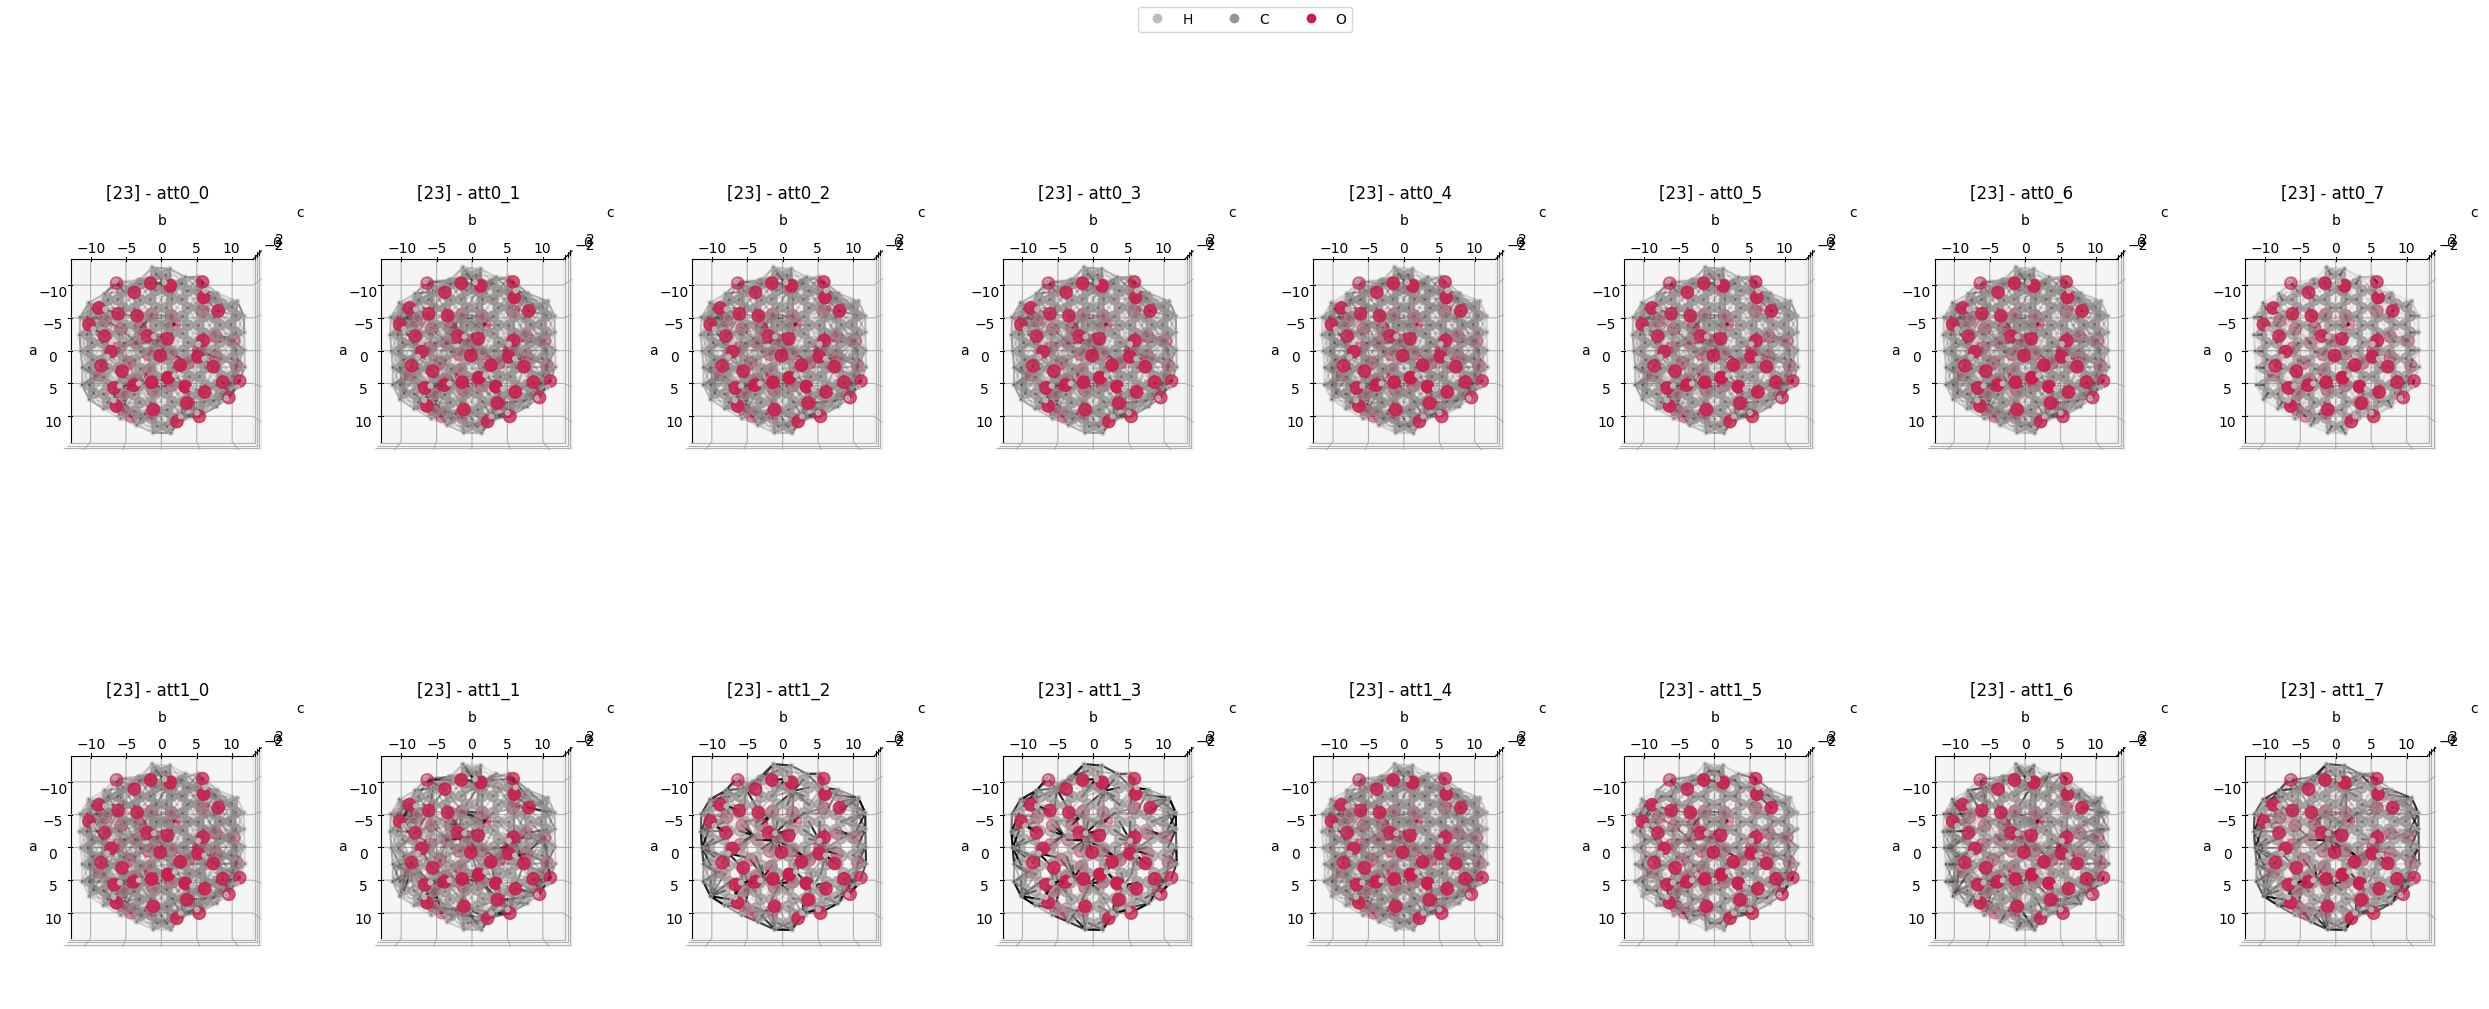

In [18]:
GO_model = GO_model.to('cpu')
g = g.to('cpu')

with torch.no_grad():
    nfeats = g.ndata['node_type']
    efeats = g.edata['bond_dist_exp']
    pred1,attns1 = compute_attentions(GO_model,g,nfeats,efeats)

display_attn_grid(g,attns1,f'{[idx]}')

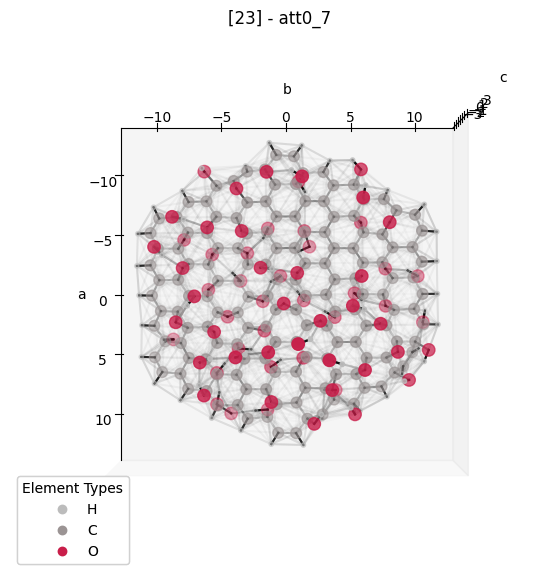

In [23]:
display_selector(g,attns1,f'{[idx]}')

### QM9 model attention

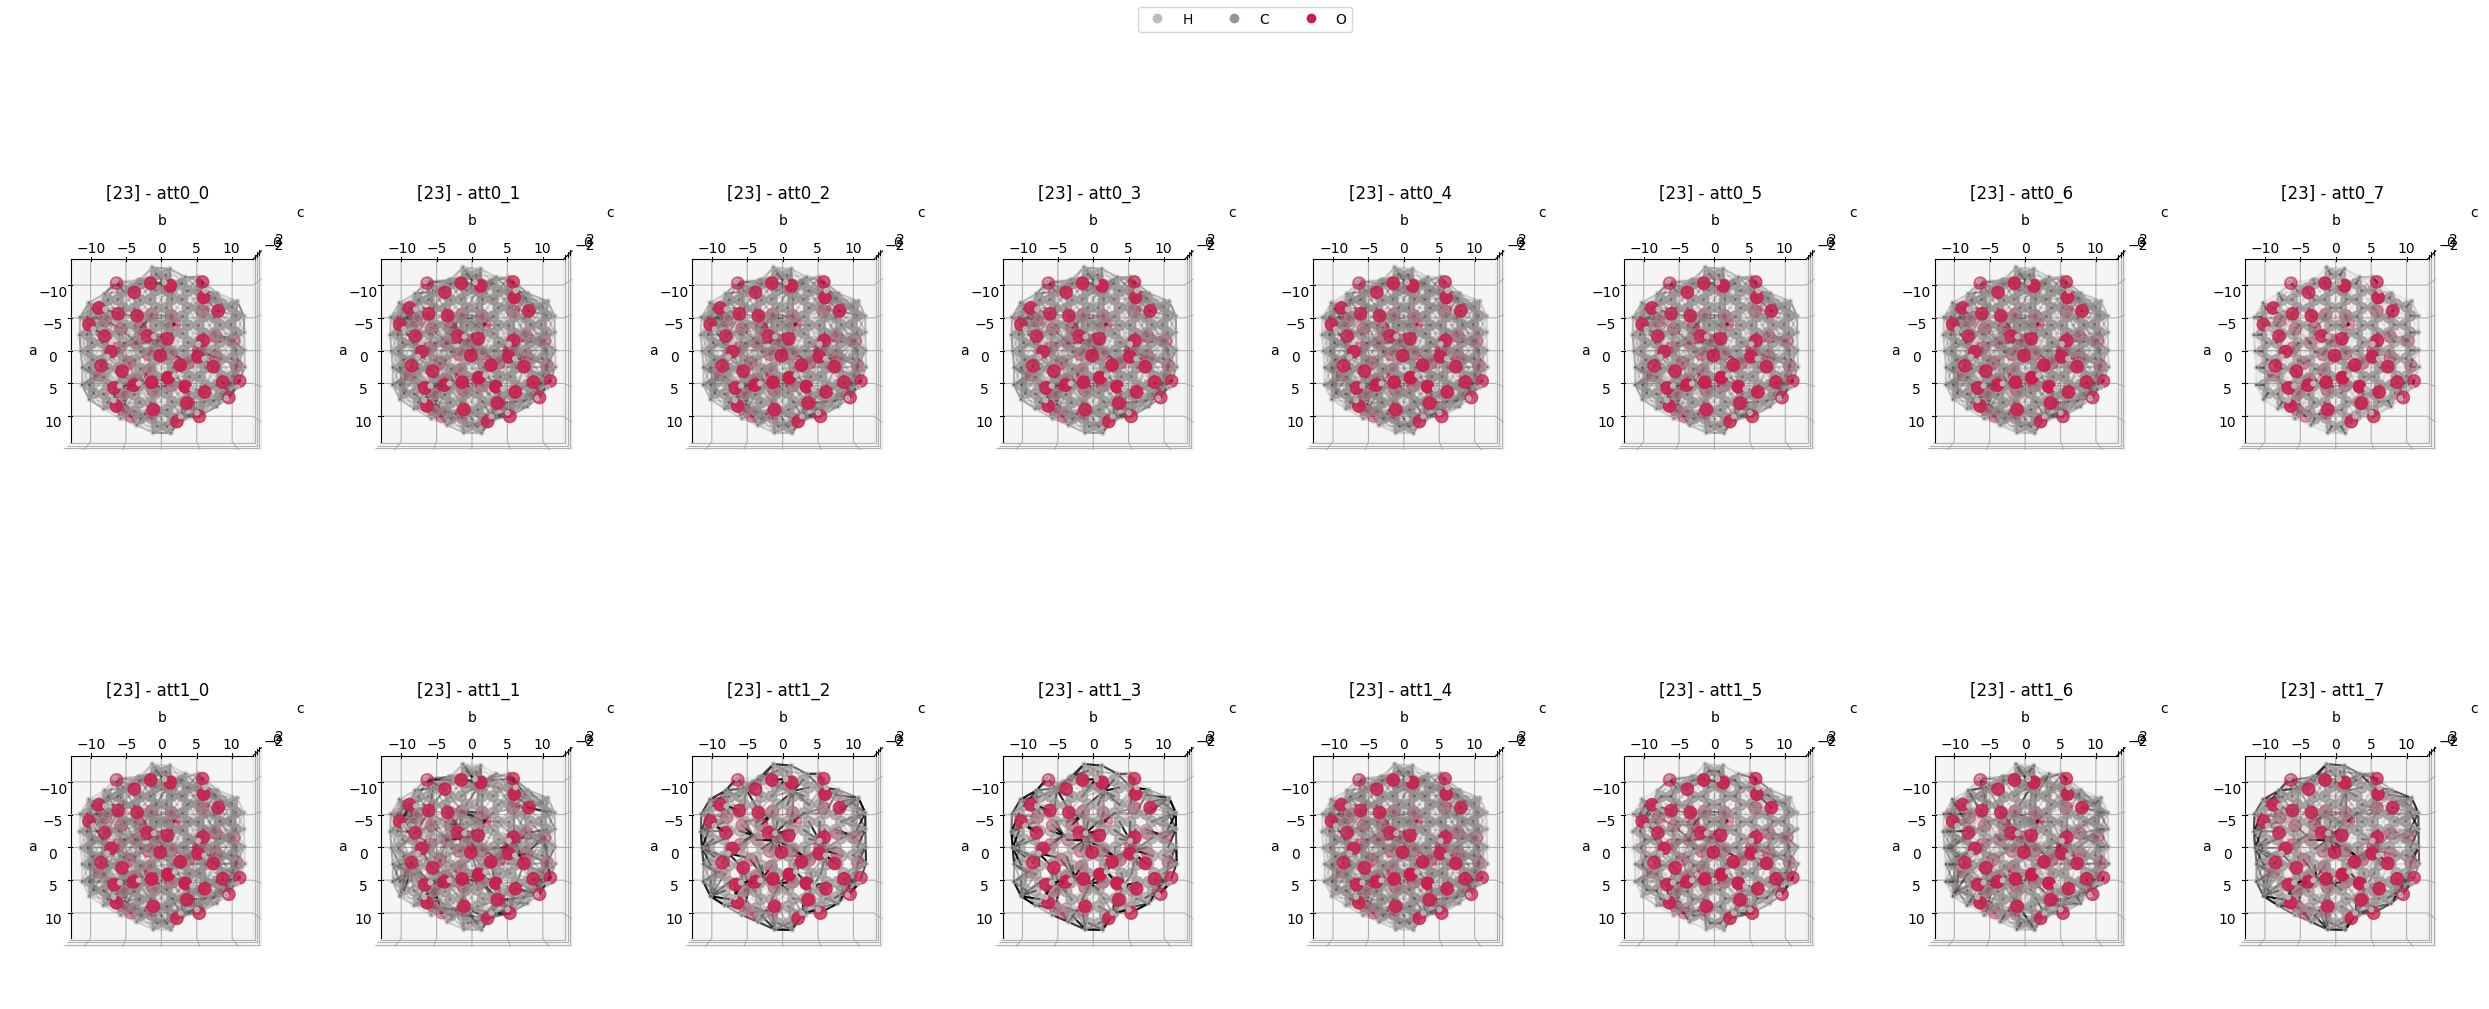

In [19]:
# GRAFO BELLISSIMO STA IN 31323
QM9_model = QM9_model.to('cuda')
g = g.to('cuda')

with torch.no_grad():
    nfeats = g.ndata['node_type']
    efeats = g.edata['bond_dist_exp']
    pred,attns2 = compute_attentions(QM9_model,g,nfeats,efeats)

g = g.to('cpu')
attns2 = [a.detach().cpu() for a in attns]
display_attn_grid(g,attns2,f'{[idx]}')

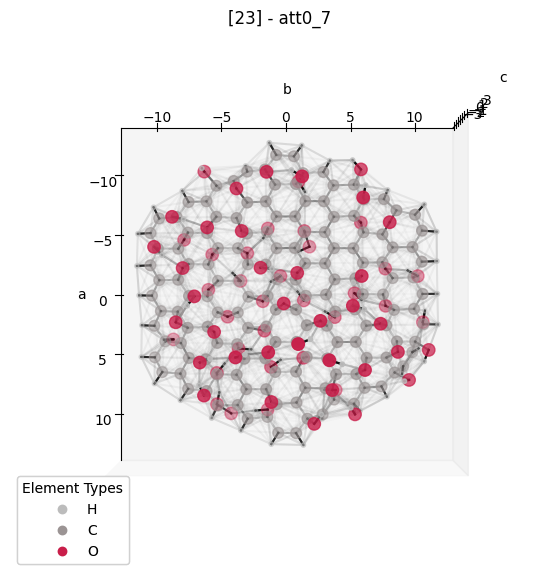

In [25]:
display_selector(g1,attns2,f'{[idx]}')

## Random QM9 molecule

In [28]:
idx = np.random.randint(len(idx_list))
g2,y = QM9_dataset[idx]
getView(g2).show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### QM9 model attention

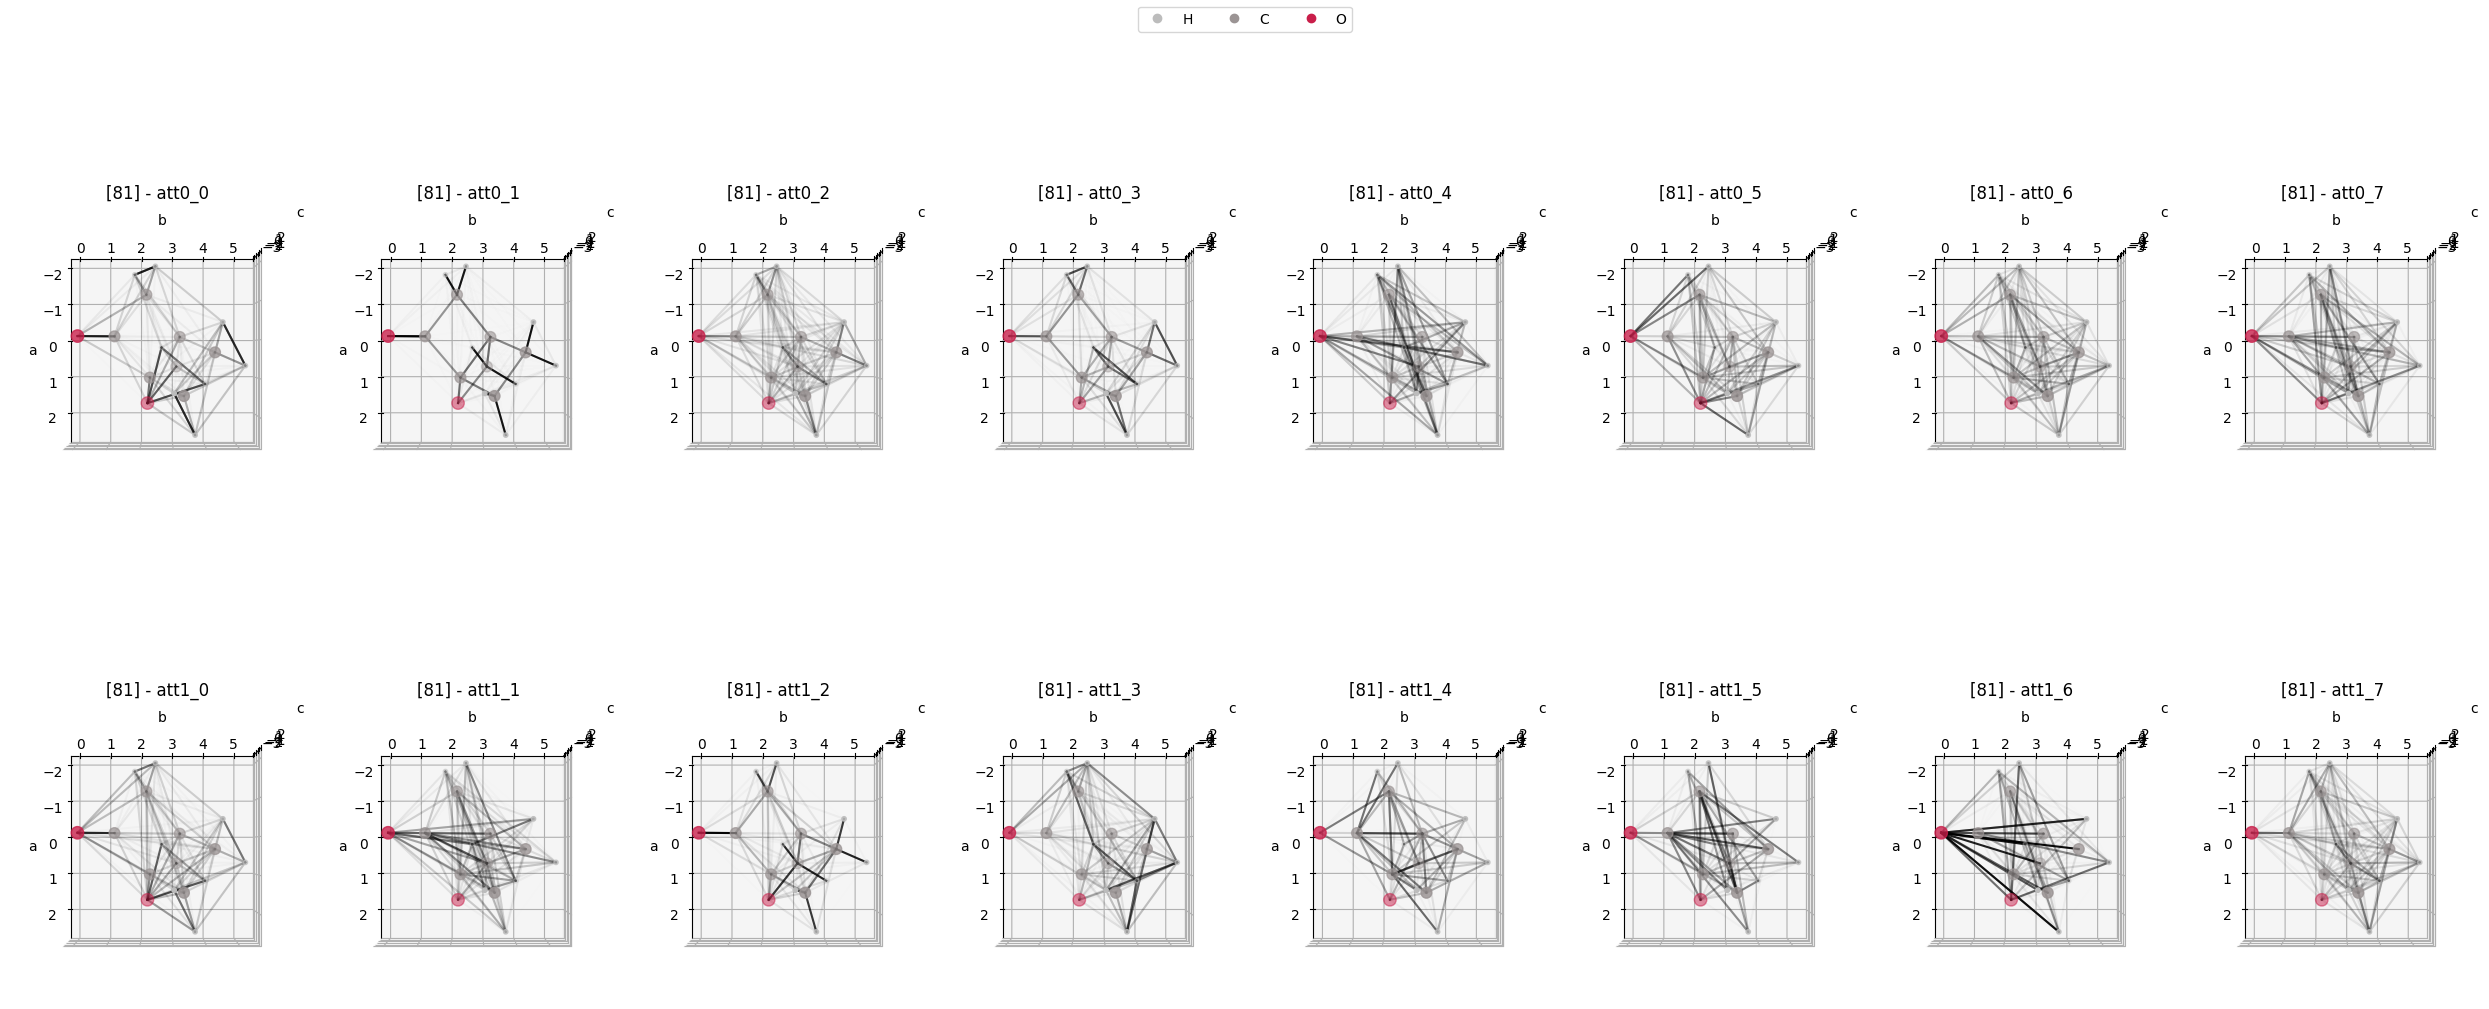

In [29]:
# GRAFO BELLISSIMO STA IN 31323
QM9_model = QM9_model.to('cpu')
g2 = g2.to('cpu')

with torch.no_grad():
    nfeats = g2.ndata['node_type']
    efeats = g2.edata['bond_dist_exp']
    pred1,attns3 = compute_attentions(QM9_model,g2,nfeats,efeats)

display_attn_grid(g2,attns3,f'{[idx]}')

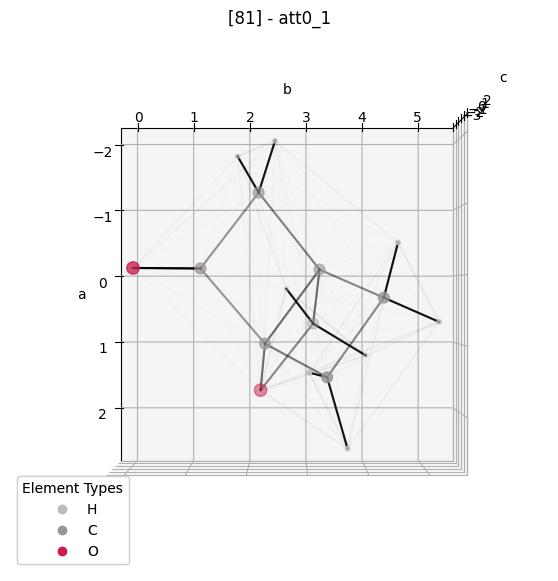

In [30]:
display_selector(g2,attns3,f'{[idx]}')

### GO model attention

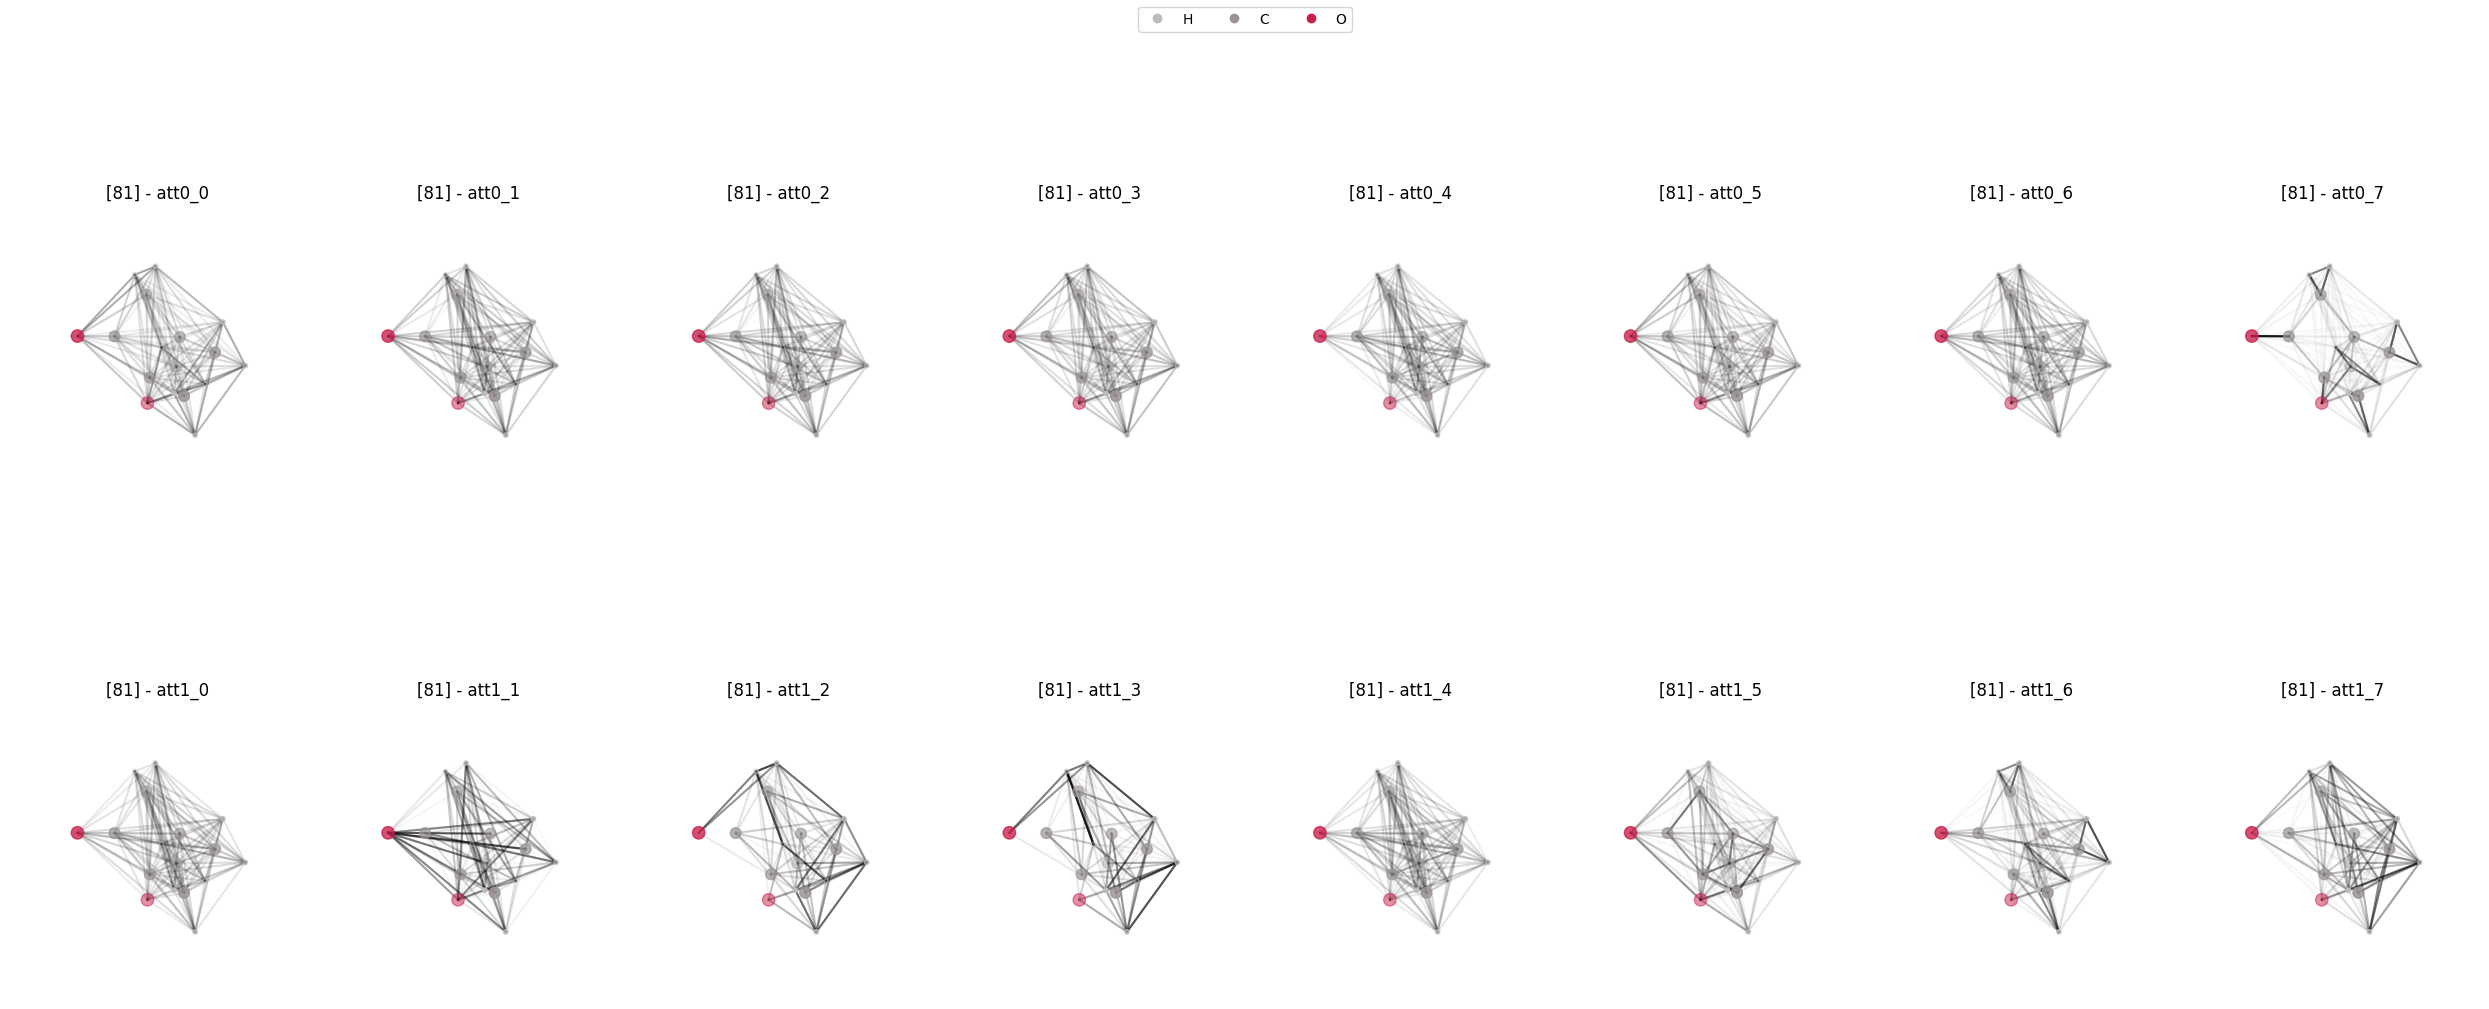

In [35]:
GO_model = GO_model.to('cpu')
g2 = g2.to('cpu')

with torch.no_grad():
    nfeats = g2.ndata['node_type']
    efeats = g2.edata['bond_dist_exp']
    pred4,attns4 = compute_attentions(GO_model,g2,nfeats,efeats)

display_attn_grid(g2,attns4,f'{[idx]}')

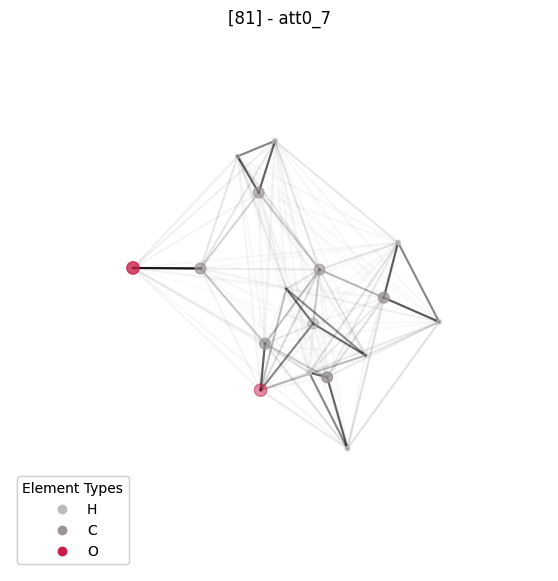

In [32]:
display_selector(g2,attns4,f'{[idx]}')